# Example - Nonisotropic Noise for REINFORCE

The following example shows how non-isotropic noise can be used to implement REINFORCE

The function that controls the recurrent noise is defined in `rnn.py`

# CLEAN UP


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


## Sample from multivariate gaussian

(50, 3)
covariance matrix shape (50, 50)
x shape (1000, 50)


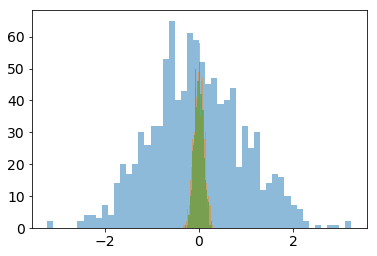

In [3]:
""" generate a positive semidefinite matrix """
a = np.random.rand(50,3) # or randn
print(a.shape)
a[1:3] *=0.1
cov = a @ a.T # can be a @ a.T or a.T @ a to be positive semidefinite

#cov = np.eye(50)


print('covariance matrix shape',cov.shape)
#cov = np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=1000)
print('x shape',x.shape)
plt.hist(x[:,0],bins=50,alpha=0.5)
plt.hist(x[:,1],bins=50,alpha=0.5)
plt.hist(x[:,2],bins=50,alpha=0.5)
#plt.hist(x[:,3],bins=50,alpha=0.5)
plt.show()

(array([2., 1., 0., 2., 2., 2., 1., 4., 4., 2., 4., 5., 4., 4., 4., 2., 0.,
        2., 2., 3.]),
 array([-1.68741954, -1.57311221, -1.45880488, -1.34449756, -1.23019023,
        -1.1158829 , -1.00157557, -0.88726825, -0.77296092, -0.65865359,
        -0.54434626, -0.43003893, -0.31573161, -0.20142428, -0.08711695,
         0.02719038,  0.14149771,  0.25580503,  0.37011236,  0.48441969,
         0.59872702]),
 <a list of 20 Patch objects>)

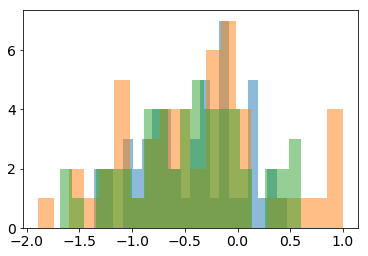

In [4]:
plt.hist(x[0,:],alpha=0.5,bins=20)
plt.hist(x[1,:],alpha=0.5,bins=20)
plt.hist(x[2,:],alpha=0.5,bins=20)

### Train RNN on four targets

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# REINFORCE with nonisotropic noise

8it [00:00, 75.83it/s]

(50, 3)


100it [00:01, 87.57it/s]


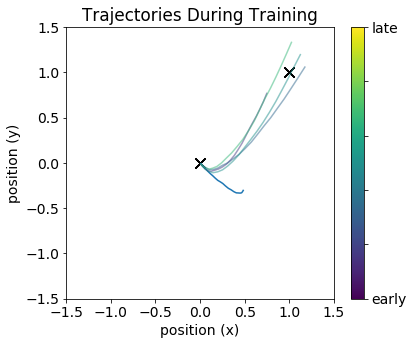

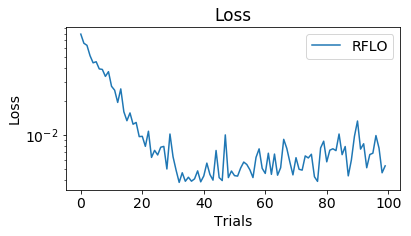

In [5]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=True, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(4))


""" generate a positive semidefinite matrix """
a = np.random.rand(50,3) # or randn
print(a.shape)
a[1:10] *=0.0
cov = a @ a.T

# Initialize RNN
net0 = RNN(params,sig_rec_covariance=cov)
sim0 = Simulation(net0)
#reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # something strange happening here
rflo = RFLO(net0,apply_to=['w_rec'],online=False) # something strange happening here
sim0.run_session(n_trials=100, tasks=[task1], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)




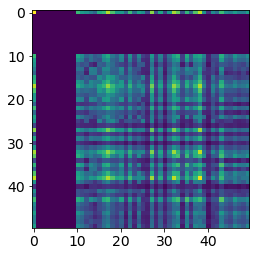

In [15]:
plt.imshow(net0.sig_rec_covariance)

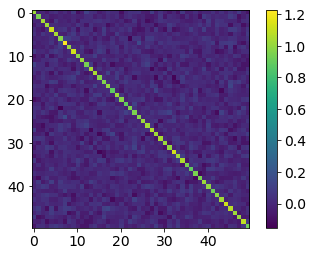

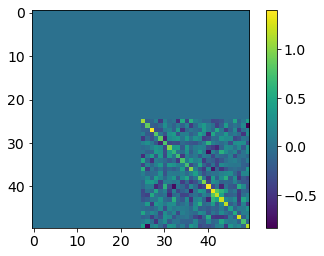

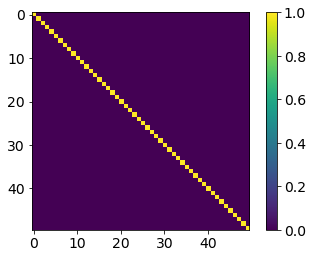

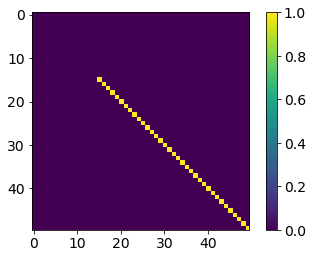

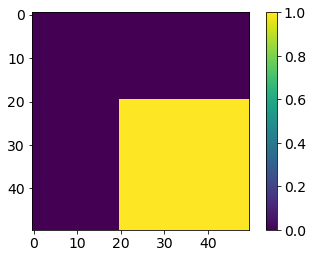

In [66]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(4))


""" generate a positive semidefinite matrix """
a = np.random.randn(50,500)/np.sqrt(500) # or randn
A = a @ a.T

b = np.random.randn(50,10)/np.sqrt(10) # or randn
b[0:25] *=0.0
B = b @ b.T

C = np.eye(50)

d = np.eye(50)
d[0:15] *=0.0
D = d @ d.T

e = np.ones((50,10))/np.sqrt(10)
e[0:20] *=0.0
E = e @ e.T

for cov in [A, B, C, D, E]:

    plt.imshow(cov)
    plt.colorbar()
    plt.show()




In [55]:
np.sum(A[5,:])

12.647117056207017

In [ ]:
x = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov=E, size=1000)
print('x shape',x.shape)
#plt.hist(x[:,0],bins=50,alpha=0.5)
#plt.hist(x[:,1],bins=50,alpha=0.5)
plt.hist(x[:,30],bins=50,alpha=0.5)

y = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov=A, size=1000)
print('x shape',x.shape)
plt.hist(y[:,0],bins=50,alpha=0.5)
plt.hist(y[:,4],bins=50,alpha=0.5)

In [ ]:
plt.plot(x[1,:])

1000it [00:16, 62.35it/s]
1000it [00:10, 93.08it/s]


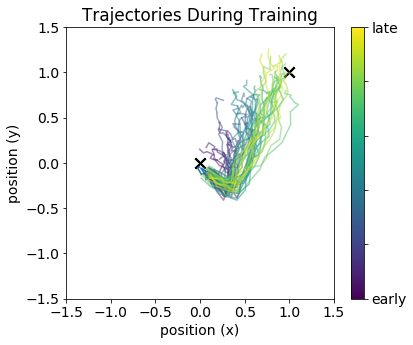

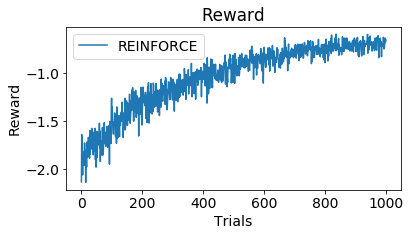

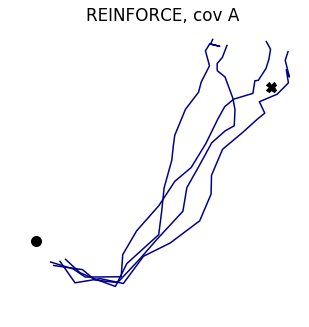

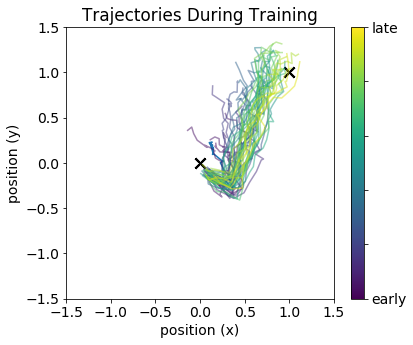

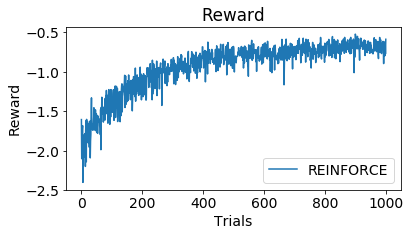

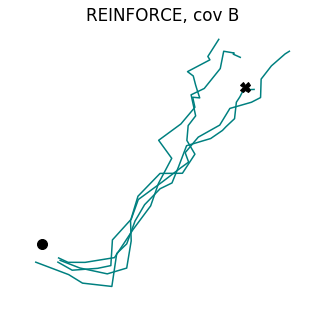

In [59]:
for cov,name in zip([A,B],['A','B']):

    # Initialize RNN
    net0 = RNN(params,sig_rec_covariance=cov)
    sim0 = Simulation(net0)
    reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # something strange happening here
    sim0.run_session(n_trials=1000, tasks=[task1], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=20)

    fig = plot_trained_trajectories(sim=sim0, tasks=[task1],title='REINFORCE, cov '+name)

1000it [00:10, 94.88it/s]


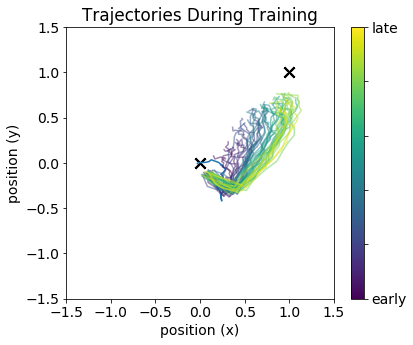

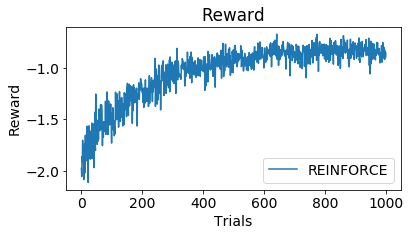

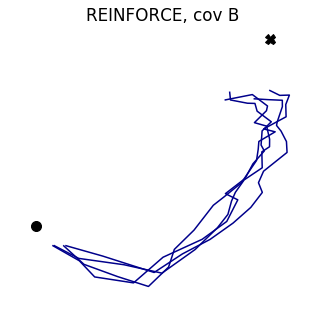

In [67]:
for cov,name in zip([B],['B']):

    # Initialize RNN
    net0 = RNN(params,sig_rec_covariance=cov)
    sim0 = Simulation(net0)
    reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # something strange happening here
    sim0.run_session(n_trials=1000, tasks=[task1], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=20)

    fig = plot_trained_trajectories(sim=sim0, tasks=[task1],title='REINFORCE, cov '+name)

1000it [00:10, 99.01it/s]
1000it [00:10, 98.62it/s]


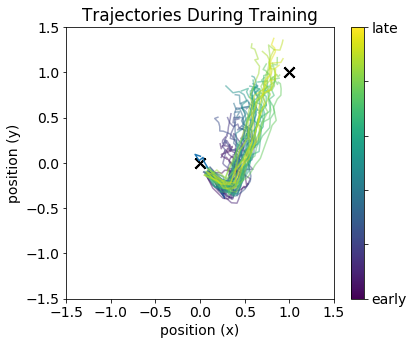

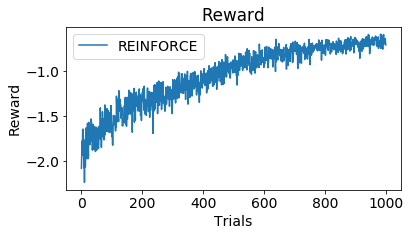

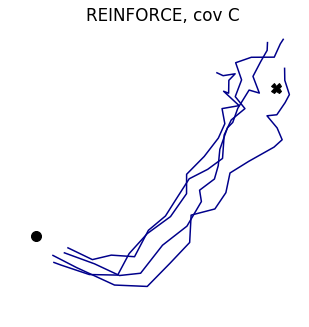

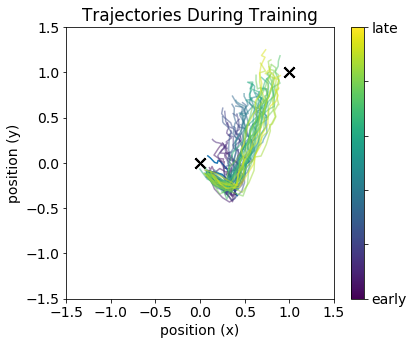

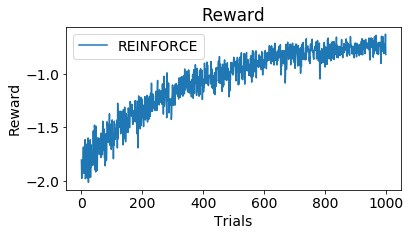

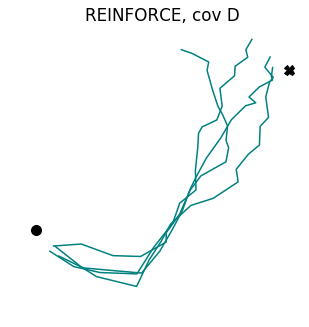

In [43]:
for cov,name in zip([C,D],['C','D']):

    # Initialize RNN
    net0 = RNN(params,sig_rec_covariance=cov)
    sim0 = Simulation(net0)
    reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # something strange happening here
    sim0.run_session(n_trials=1000, tasks=[task1], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=20)

    fig = plot_trained_trajectories(sim=sim0, tasks=[task1],title='REINFORCE, cov '+name)

1000it [00:10, 96.32it/s]


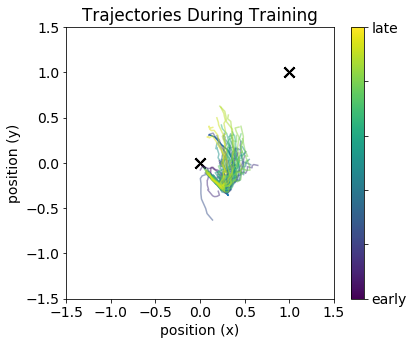

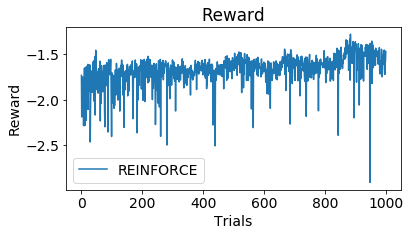

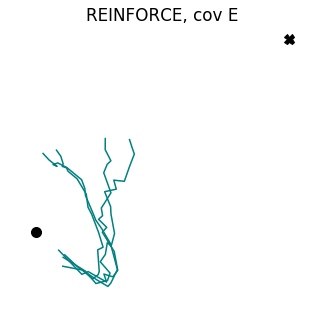

In [46]:
for cov,name in zip([10*E],['E']):

    # Initialize RNN
    net0 = RNN(params,sig_rec_covariance=cov)
    sim0 = Simulation(net0)
    reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # something strange happening here
    sim0.run_session(n_trials=1000, tasks=[task1], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=20)

    fig = plot_trained_trajectories(sim=sim0, tasks=[task1],title='REINFORCE, cov '+name)

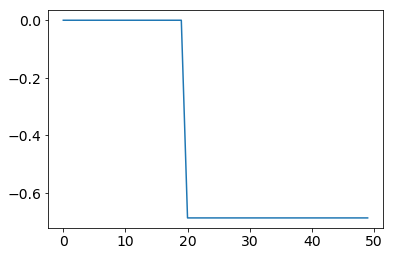